In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from tqdm.notebook import tqdm

# Set paths (update these according to your setup)
COCO_PATH = "../../data/coco/"
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

DS_SIZE = (0.1, 0.1, 0.1)
BATCH_SIZE = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class COCOKeypointsDataset(Dataset):
    def __init__(self, img_dir, ann_file, img_size=416, grid_size=13, transform=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.img_ids = list(self.coco.imgs.keys())
        self.img_size = img_size
        self.grid_size = grid_size
        self.transform = transform
        self.cell_size = img_size / grid_size
        
        # Filter images with at least one person
        valid_ids = []
        for img_id in self.img_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[1])  # Category 1: person
            anns = self.coco.loadAnns(ann_ids)
            if len(anns) > 0:
                valid_ids.append(img_id)
        self.img_ids = valid_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        orig_w, orig_h = img.size
        
        # Resize and transform image
        if self.transform:
            img = self.transform(img)
        
        # Initialize target grid tensor
        # Format: [obj, x, y, w, h, kp_x1, kp_y1, kp_v1, ...] for 17 keypoints
        target = torch.zeros((self.grid_size, self.grid_size, 1 + 4 + 17 * 3))
        
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[1])
        anns = self.coco.loadAnns(ann_ids)
        
        for ann in anns:
            # Skip crowd annotations
            if ann.get('iscrowd', 0):
                continue
                
            # Get bounding box and keypoints
            x, y, w, h = ann['bbox']
            keypoints = np.array(ann['keypoints']).reshape(-1, 3)
            
            # Scale to image_size
            scale_x = self.img_size / orig_w
            scale_y = self.img_size / orig_h
            
            # Scale bounding box
            x = x * scale_x
            y = y * scale_y
            w = w * scale_x
            h = h * scale_y
            
            # Calculate grid cell
            cx = x + w / 2
            cy = y + h / 2
            grid_x = int(cx / self.cell_size)
            grid_y = int(cy / self.cell_size)
            
            # Skip if out of bounds
            if grid_x >= self.grid_size or grid_y >= self.grid_size:
                continue
                
            # Objectness score
            target[grid_y, grid_x, 0] = 1
            
            # Bounding box (relative to cell)
            target[grid_y, grid_x, 1] = (cx - grid_x * self.cell_size) / self.cell_size
            target[grid_y, grid_x, 2] = (cy - grid_y * self.cell_size) / self.cell_size
            target[grid_y, grid_x, 3] = w / self.img_size
            target[grid_y, grid_x, 4] = h / self.img_size
            
            # Keypoints
            for k, (x_k, y_k, v_k) in enumerate(keypoints):
                offset = 5 + k * 3
                x_k = x_k * scale_x
                y_k = y_k * scale_y
                
                # Keypoint coordinates relative to cell
                target[grid_y, grid_x, offset] = (x_k - grid_x * self.cell_size) / self.cell_size
                target[grid_y, grid_x, offset + 1] = (y_k - grid_y * self.cell_size) / self.cell_size
                target[grid_y, grid_x, offset + 2] = 1 if v_k == 2 else 0  # 2=visible
        
        return img, target


In [3]:

# Transformations
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create datasets with DS_SIZE
num_train = int(len(os.listdir(IMG_DIR_TRAIN)) * DS_SIZE[0])
num_val = int(len(os.listdir(IMG_DIR_VAL)) * DS_SIZE[1])
num_test = int(len(os.listdir(IMG_DIR_VAL)) * DS_SIZE[2])

train_dataset = COCOKeypointsDataset(
    IMG_DIR_TRAIN, ANN_FILE_TRAIN, transform=transform
)
val_dataset = COCOKeypointsDataset(
    IMG_DIR_VAL, ANN_FILE_VAL, transform=transform
)

# Subsample datasets according to DS_SIZE
train_indices = list(range(len(train_dataset)))
val_indices = list(range(len(val_dataset)))

random.shuffle(train_indices)
random.shuffle(val_indices)

train_subset = torch.utils.data.Subset(train_dataset, train_indices[:num_train])
val_subset = torch.utils.data.Subset(val_dataset, val_indices[:num_val])
test_subset = torch.utils.data.Subset(val_dataset, val_indices[num_val:num_val+num_test])

# Data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

loading annotations into memory...
Done (t=6.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [4]:
class KeypointYOLO(nn.Module):
    def __init__(self):
        super(KeypointYOLO, self).__init__()
        self.grid_size = 13
        self.num_keypoints = 17
        
        # Feature extractor (simplified Darknet)
        self.features = nn.Sequential(
            # Input: 3x416x416
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 208x208
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 104x104
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 52x52
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 26x26
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # 13x13
        )
        
        # Detection head
        self.detector = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, (1 + 4 + 3 * self.num_keypoints), 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.detector(x)
        # Reshape: (batch, channels, grid, grid) -> (batch, grid, grid, channels)
        x = x.permute(0, 2, 3, 1)
        return x

In [5]:
class KeypointLoss(nn.Module):
    def __init__(self, kappa=None):
        super().__init__()
        # COCO recommended kappa values for 17 keypoints (in order)
        # [nose, left_eye, right_eye, left_ear, right_ear, left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle]
        if kappa is None:
            self.kappa = torch.tensor([
                0.026, 0.025, 0.025, 0.035, 0.035,
                0.079, 0.079, 0.072, 0.072, 0.062, 0.062,
                0.107, 0.107, 0.087, 0.087, 0.089, 0.089
            ]).view(1, 1, 1, 17)
        else:
            self.kappa = torch.tensor(kappa).view(1, 1, 1, 17)

    def forward(self, preds, targets):
        # preds, targets: (batch, grid, grid, 1+4+51)
        obj_mask = targets[..., 0] == 1  # (batch, grid, grid)
        if obj_mask.sum() == 0:
            return torch.tensor(0.0, device=preds.device, requires_grad=True)

        oks_sum = 0.0
        num_objects = 0

        kappa_device = self.kappa.to(preds.device)

        for b in range(preds.shape[0]):
            for gy in range(preds.shape[1]):
                for gx in range(preds.shape[2]):
                    if obj_mask[b, gy, gx]:
                        # Get predicted and target keypoints for this object
                        pred_kps = preds[b, gy, gx, 5:].view(17, 3)
                        target_kps = targets[b, gy, gx, 5:].view(17, 3)
                        vis = target_kps[:, 2]  # (17,)
                        labeled = vis > 0

                        if labeled.sum() == 0:
                            continue

                        # Predicted and target coordinates
                        pred_xy = pred_kps[:, :2][labeled]
                        target_xy = target_kps[:, :2][labeled]

                        # Compute object scale s (sqrt of area, area = w*h)
                        w = targets[b, gy, gx, 3] * 416
                        h = targets[b, gy, gx, 4] * 416
                        s = torch.sqrt(w * h + 1e-6)

                        # Move kappa to device before indexing
                        kappa = kappa_device[0, 0, 0, labeled]

                        # Compute squared distances
                        d2 = ((pred_xy - target_xy) ** 2).sum(dim=1)

                        # OKS for this object
                        oks = torch.exp(-d2 / (2 * (s * kappa) ** 2)).sum() / labeled.sum()
                        oks_sum += oks
                        num_objects += 1

        if num_objects == 0:
            return torch.tensor(0.0, device=preds.device, requires_grad=True)
        # Loss is 1 - mean OKS (maximize OKS)
        return 1.0 - oks_sum / num_objects

In [6]:
# class KeypointLoss(nn.Module):
#     def __init__(self, kappa=None, lambda_obj=1.0, lambda_box=1.0, lambda_kp=1.0):
#         super().__init__()
#         self.lambda_obj = lambda_obj
#         self.lambda_box = lambda_box
#         self.lambda_kp = lambda_kp
#         if kappa is None:
#             self.kappa = torch.tensor([
#                 0.026, 0.025, 0.025, 0.035, 0.035,
#                 0.079, 0.079, 0.072, 0.072, 0.062, 0.062,
#                 0.107, 0.107, 0.087, 0.087, 0.089, 0.089
#             ]).view(1, 1, 1, 17)
#         else:
#             self.kappa = torch.tensor(kappa).view(1, 1, 1, 17)
#         self.bce = nn.BCEWithLogitsLoss()
#         self.mse = nn.MSELoss()

#     def forward(self, preds, targets):
#         obj_mask = targets[..., 0] == 1  # (batch, grid, grid)
#         noobj_mask = targets[..., 0] == 0

#         # Objectness loss
#         obj_loss = self.mse(preds[..., 0][obj_mask], targets[..., 0][obj_mask])
#         noobj_loss = self.mse(preds[..., 0][noobj_mask], targets[..., 0][noobj_mask])
#         objectness_loss = obj_loss + 0.5 * noobj_loss

#         # Box loss (only where object exists)
#         box_loss = self.mse(preds[..., 1:5][obj_mask], targets[..., 1:5][obj_mask])

#         # Keypoint loss (only for visible keypoints)
#         kp_loss = 0.0
#         for k in range(17):
#             kp_x = 5 + k * 3
#             kp_y = 5 + k * 3 + 1
#             kp_v = 5 + k * 3 + 2
#             vis = targets[..., kp_v][obj_mask] > 0.5
#             if vis.sum() > 0:
#                 kp_loss += self.mse(preds[..., kp_x][obj_mask][vis], targets[..., kp_x][obj_mask][vis])
#                 kp_loss += self.mse(preds[..., kp_y][obj_mask][vis], targets[..., kp_y][obj_mask][vis])

#         total_loss = (
#             self.lambda_obj * objectness_loss +
#             self.lambda_box * box_loss +
#             self.lambda_kp * kp_loss
#         )
#         return total_loss


In [7]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, starting_epoch=1):
    model = model.to(device)
    criterion = KeypointLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(starting_epoch-1, num_epochs):
        # Training
        model.train()
        train_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, targets in loop:
            images = images.to(device)
            targets = targets.to(device)
            
            # Forward pass
            preds = model(images)
            loss = criterion(preds, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                preds = model(images)
                loss = criterion(preds, targets)
                val_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}")
    
    return model



In [8]:
# Initialize and train model
model = KeypointYOLO()
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=1e-4
)

# Save model
torch.save(trained_model.state_dict(), "keypoint_yolo2.pth")

Epoch 1/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.0366 | Val Loss: 0.0338


Epoch 2/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 0.0295 | Val Loss: 0.0318


Epoch 3/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.0259 | Val Loss: 0.0313


Epoch 4/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.0228 | Val Loss: 0.0357


Epoch 5/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.0199 | Val Loss: 0.0281


Epoch 6/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.0179 | Val Loss: 0.0308


Epoch 7/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.0162 | Val Loss: 0.0308


Epoch 8/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.0147 | Val Loss: 0.0278


Epoch 9/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.0134 | Val Loss: 0.0357


Epoch 10/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.0129 | Val Loss: 0.0280


Epoch 11/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.0117 | Val Loss: 0.0325


Epoch 12/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.0108 | Val Loss: 0.0282


Epoch 13/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.0102 | Val Loss: 0.0315


Epoch 14/100:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.0097 | Val Loss: 0.0327


Epoch 15/100:   0%|          | 0/370 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
def visualize_predictions(image, preds, threshold=0.5):
    # Convert image to numpy
    img = image.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Process predictions
    grid_size = preds.shape[0]
    cell_size = 416 / grid_size
    
    for gy in range(grid_size):
        for gx in range(grid_size):
            if preds[gy, gx, 0] > threshold:  # Object detected
                # Get bounding box
                bx = (gx + preds[gy, gx, 1]) * cell_size
                by = (gy + preds[gy, gx, 2]) * cell_size
                bw = preds[gy, gx, 3] * 416
                bh = preds[gy, gx, 4] * 416
                
                # Draw rectangle
                rect = plt.Rectangle(
                    (bx - bw/2, by - bh/2), bw, bh,
                    fill=False, edgecolor='red', linewidth=1
                )
                ax.add_patch(rect)
                
                # Draw keypoints
                for k in range(17):
                    if preds[gy, gx, 5 + k*3 + 2] > 0.5:  # Visible keypoint
                        kx = (gx + preds[gy, gx, 5 + k*3]) * cell_size
                        ky = (gy + preds[gy, gx, 5 + k*3 + 1]) * cell_size
                        ax.scatter(kx, ky, s=20, c='blue')
    
    plt.show()



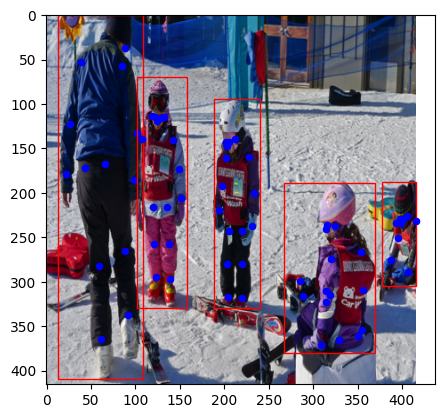

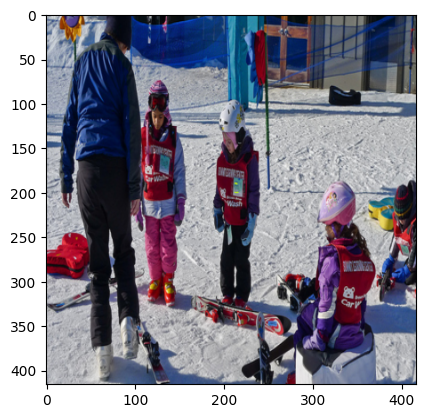

[[[-0.37184465  0.40495315  0.0920116  ...  0.9034039   1.6948221
    0.4521585 ]
  [ 0.07804494  0.22953172 -0.2289852  ...  0.26839706  1.443047
    0.49487817]
  [ 0.11720625  0.3330125  -0.21797034 ...  0.38539565  1.5605856
    0.5103769 ]
  ...
  [-0.01717597  0.14343414  0.03400323 ...  0.3796664   1.2692721
    0.19037333]
  [ 0.17934626  0.19832473  0.0131995  ...  0.26019433  1.5556271
    0.25969535]
  [-0.04366595  0.27293974  0.03603917 ...  0.37186718  1.6932975
    0.26991704]]

 [[-0.18563506 -0.2656089  -0.22483724 ...  0.9354739   1.5597413
   -0.3798755 ]
  [ 0.0509096   0.18209758 -0.46641862 ...  0.47872782  1.6547692
    0.16168143]
  [-0.15691051  0.19120207 -0.41397673 ...  0.5172378   2.1076648
    0.61461854]
  ...
  [ 0.05658522  0.13369903 -0.30466208 ...  0.3658951   1.4952395
    0.10826728]
  [ 0.2697909   0.10077505 -0.20490442 ...  0.47866657  1.6178118
    0.15303822]
  [-0.15830542  0.33769172  0.01581625 ...  0.5279915   1.8629037
    0.21613199]]

 

In [10]:
# Load a random sample image from the test set
model.eval()
sample_idx = random.randint(0, len(train_dataset) - 1)
sample_img, sample_target = train_dataset[sample_idx]
sample_img = sample_img.unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    preds = model(sample_img.to(device))[0].cpu().numpy()

    # Visualize ground truth
    visualize_predictions(sample_img[0], sample_target.numpy(), threshold=0.5)

# Visualize model prediction
visualize_predictions(sample_img[0], preds)

print(preds)